# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

# Configuration Reading from File

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
name = 'odd_run9.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 840

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    z_corr[ic][t][inoise] = complex(re,im)

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152124
Reading: Gauge Conf = 2

2319488
Reading: Gauge Conf = 3

3486852
Reading: Gauge Conf = 4

4654216
Reading: Gauge Conf = 5

5821580
Reading: Gauge Conf = 6

6988944
Reading: Gauge Conf = 7

8156308
Reading: Gauge Conf = 8

9323672
Reading: Gauge Conf = 9

10491036
Reading: Gauge Conf = 10

11658400
Reading: Gauge Conf = 11

12825764
Reading: Gauge Conf = 12

13993128
Reading: Gauge Conf = 13

15160492
Reading: Gauge Conf = 14

16327856
Reading: Gauge Conf = 15

17495220
Reading: Gauge Conf = 16

18662584
Reading: Gauge Conf = 17

19829948
Reading: Gauge Conf = 18

20997312
Reading: Gauge Conf = 19

22164676
Reading: Gauge Conf = 20

23332040
Reading: Gauge Conf = 21

24499404
Reading: Gauge Conf = 22

25666768
Reading: Gauge Conf = 23

26834132
Reading: Gauge Conf = 24

28001496
Reading: Gauge Conf = 25

29168860
Reading: Gauge Conf = 26

30336224
Reading: Gauge Conf = 27

31503588
Reading: Gauge Conf = 28

32670952
Reading: Gauge Conf = 29

33838316
Re

In [7]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/(offset_3point+offset_2point+4)

991.0

In [8]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [9]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

In [10]:
if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(151, 2, 1, 5, 32, 15, 15)


In [11]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(151, 1, 32, 15)
(151, 1, 32, 15)


# Jackknife Preparation

## Average over noise

In [12]:
all_2point_x_navg = all_2point_x.mean(axis=-1)
all_2point_z_navg = all_2point_z.mean(axis=-1)

if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(all_2point_x_navg))
    print(np.shape(all_2point_z_navg))

all_correlators_navg = all_correlators.mean(axis=-1).mean(axis=-1)
all_correlators_navg_tot = all_correlators_navg[:,0,:,:,:] + all_correlators_navg[:,1,:,:,:]

if verbose:
    print("(nconf, ncorrelators, noperators, tvals)")
    print(np.shape(all_correlators_navg_tot))

(nconf, ncorrelators, tvals)
(151, 1, 32)
(151, 1, 32)
(nconf, ncorrelators, noperators, tvals)
(151, 1, 5, 32)


## Creation of Jackknife Replicates

In [13]:
delta = 1

jack_replicates_x = np.asarray( [np.delete(all_2point_x_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0).mean(axis=0) for iconf in range(0,nconf,delta)] )
jack_replicates_z = np.asarray( [np.delete(all_2point_z_navg, list(range(iconf,min(iconf+delta,nconf))) ,axis=0).mean(axis=0) for iconf in range(0,nconf,delta)] )
jack_replicates_3 = np.asarray( [np.delete(all_correlators_navg_tot, list(range(iconf,min(iconf+delta,nconf))) ,axis=0).mean(axis=0) for iconf in range(0,nconf,delta)] )

if verbose:
    print("(nconf, ncorrelators, tvals)") #here nconf = number of jack replicates
    print(np.shape(jack_replicates_x))
    print(np.shape(jack_replicates_z))
    print("(nconf, ncorrelators, noperators, tvals)") #here nconf = number of jack replicates
    print(np.shape(jack_replicates_3))

(nconf, ncorrelators, tvals)
(151, 1, 32)
(151, 1, 32)
(nconf, ncorrelators, noperators, tvals)
(151, 1, 5, 32)


## Analysis of Normalized correlators

In [14]:
norm_3point = np.empty(shape=(nconf,ncorr,noperators,tvals),dtype=complex)
#norm_3point = np.empty(shape=(nconf,ncorr,noperators,tvals-2),dtype=complex)

for iconf in range(nconf):
    for icorr in range(ncorr):
        for iop in range(noperators):
            norm_3point[iconf,icorr,iop,:] = jack_replicates_3[iconf,icorr,iop,:]/(jack_replicates_x[iconf,icorr,:]*jack_replicates_z[iconf,icorr,:])
            #norm_3point[nconf,ic,iop,:] = jack_replicates_3[ic,iop,1:-1]/(jack_replicates_x[ic,1:-1]*jack_replicates_z[ic,1:-1])

if verbose:
    print("(nconf,ncorr,noperators,tvals)")
    print(np.shape(norm_3point))

(nconf,ncorr,noperators,tvals)
(151, 1, 5, 32)


/tmp/ipykernel_17316/564058320.py:7: RuntimeWarning: invalid value encountered in divide
  norm_3point[iconf,icorr,iop,:] = jack_replicates_3[iconf,icorr,iop,:]/(jack_replicates_x[iconf,icorr,:]*jack_replicates_z[iconf,icorr,:])


In [15]:
#check on correct calculation
if verbose:
    iconf=1
    icorr=0
    iop=3
    norm_3point[iconf,icorr,iop,20]
    jack_replicates_3[iconf,icorr,iop,20]/(jack_replicates_x[iconf,icorr,20]*jack_replicates_z[iconf,icorr,20])

(0.0002437756242101859-0.0024326355240660616j)

(0.0002437756242101859-0.0024326355240660616j)

In [16]:
#mean and std:
norm3_mean = norm_3point.mean(axis=0)
norm3_std = np.sqrt( ((nconf-1)/nconf) * np.sum( (norm_3point.imag-norm3_mean.imag)**2 ,axis=0) )

if verbose:
    print("(ncorr,noperators,tvals)")
    print(np.shape(norm3_mean))
    print(np.shape(norm3_std))

(ncorr,noperators,tvals)
(1, 5, 32)
(1, 5, 32)


In [17]:
#check on orders of magnitude of error
norm3_std/norm3_mean.imag

array([[[        nan,  0.00750611,  0.00727698,  0.00724824,
          0.00838462,  0.01024654,  0.01191137,  0.01461767,
          0.01772784,  0.02262036,  0.02941246,  0.03618502,
          0.04592926,  0.06197055,  0.08687844,  0.12264971,
          0.16919132,  0.19756612,  0.17871024,  0.16979702,
          0.15109033,  0.12676702,  0.10495284,  0.08251513,
          0.06078335,  0.04453461,  0.03308155,  0.0254972 ,
          0.02048129,  0.0170146 ,  0.01470365,         nan],
        [        nan, -0.00308888, -0.02809882, -0.0104966 ,
         -0.00983055, -0.01112229, -0.01309054, -0.0151433 ,
         -0.01805765, -0.0222564 , -0.02956259, -0.03751566,
         -0.04866486, -0.06398699, -0.08686252, -0.12313908,
         -0.16992679, -0.19562323, -0.17891499, -0.16850194,
         -0.15101599, -0.12624748, -0.10503607, -0.08424137,
         -0.0643363 , -0.05042351, -0.04045763, -0.03420114,
         -0.0297439 , -0.02580733, -0.01676902,         nan],
        [        nan, 

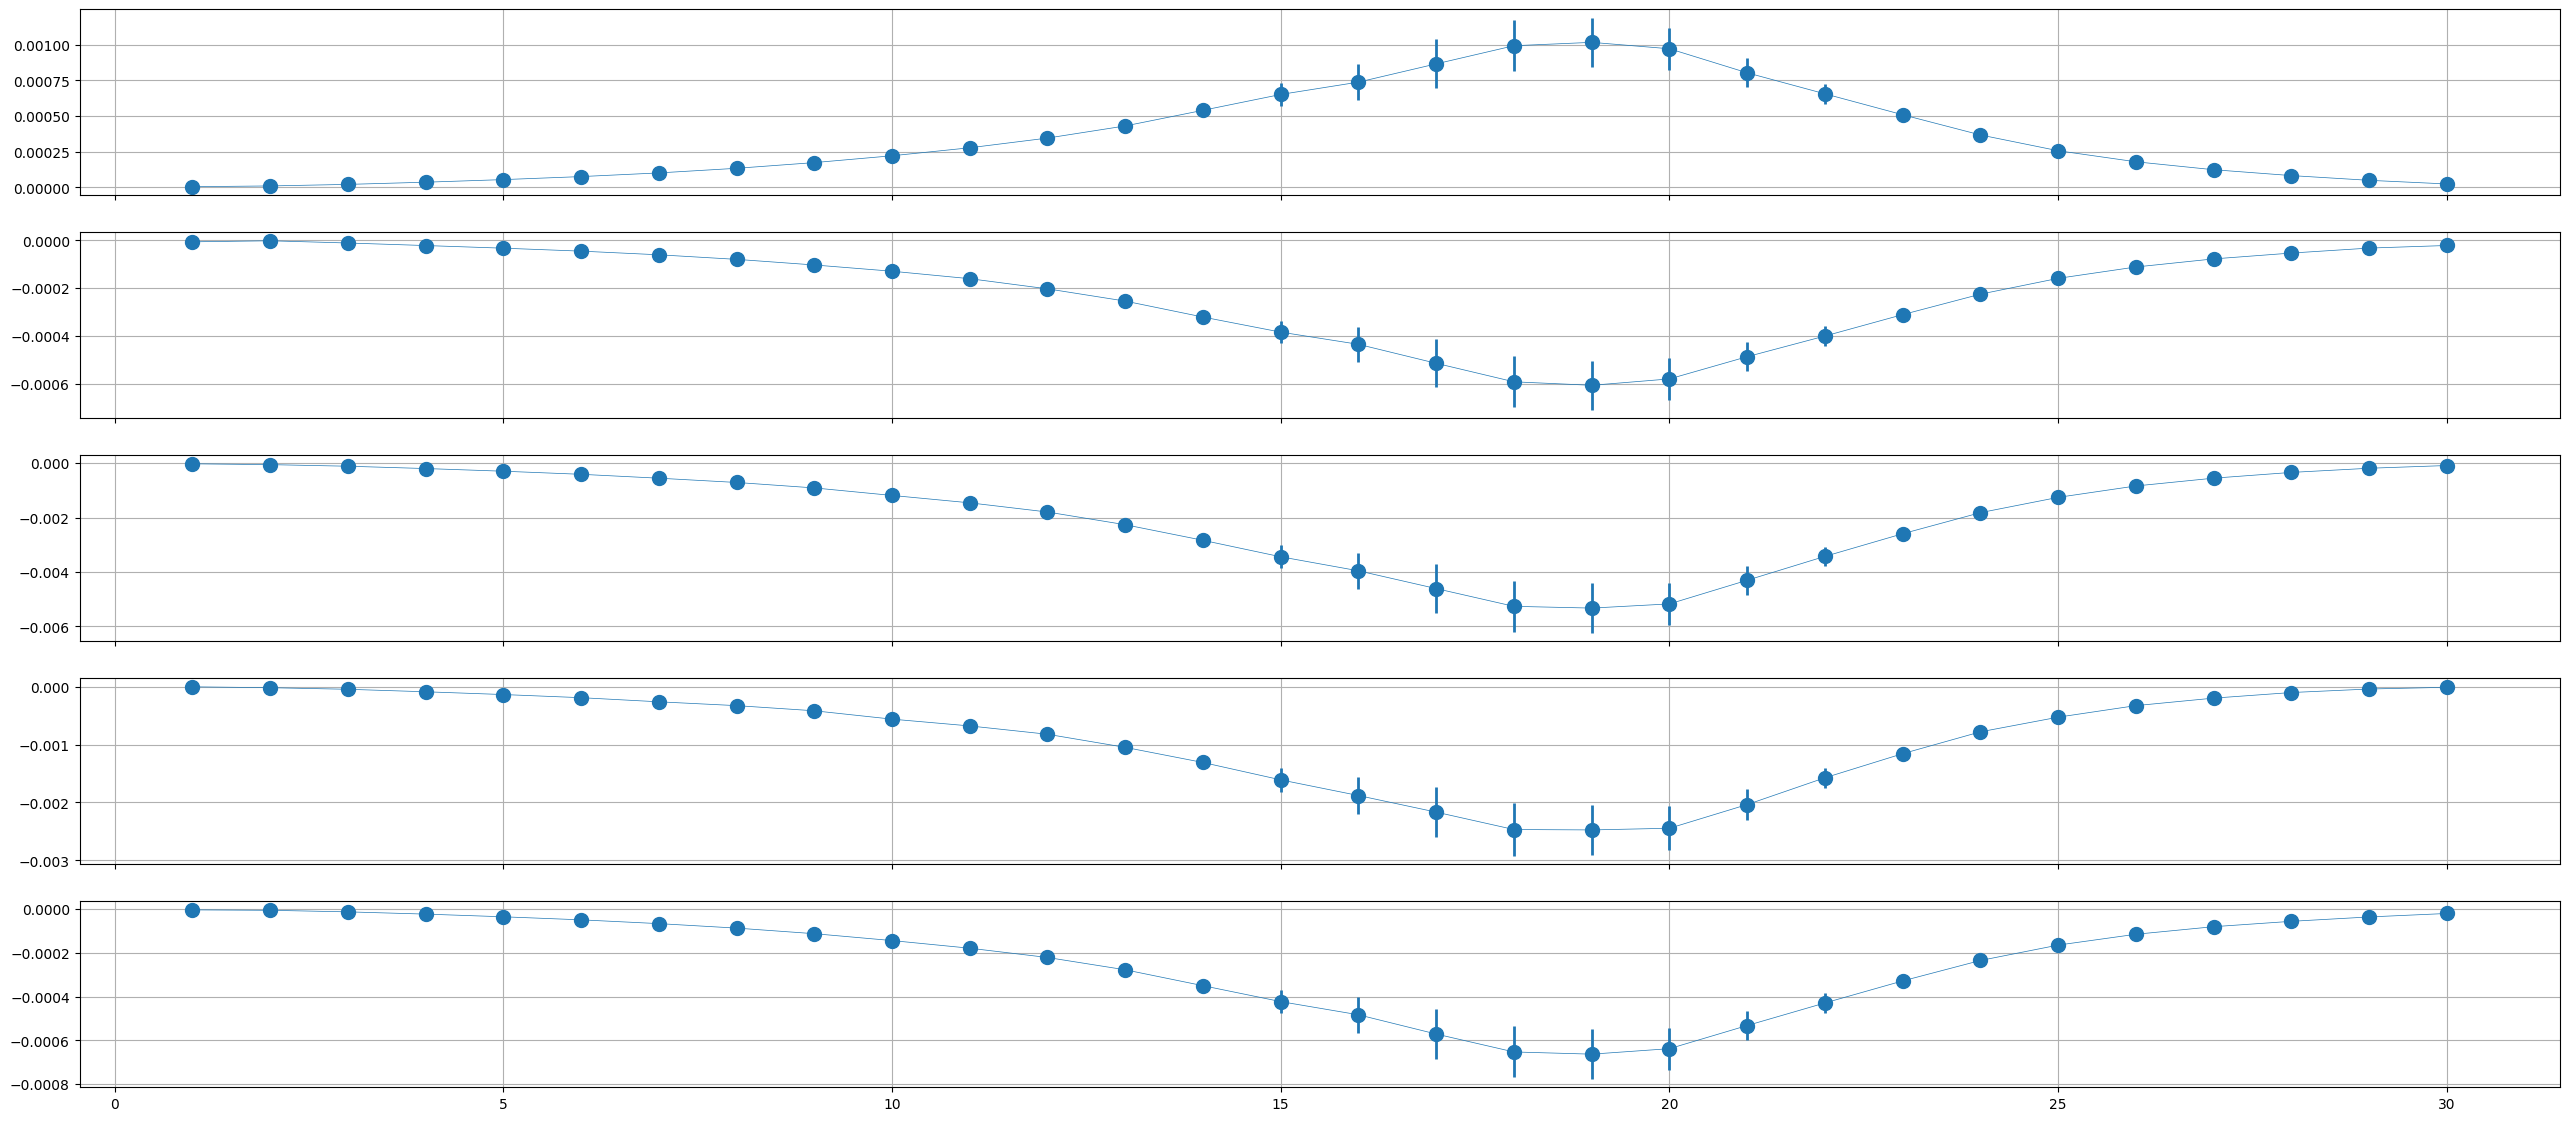

In [18]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,norm3_mean[0,iop,:].imag,yerr=norm3_std[0,iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[iop].grid()
        

plt.savefig('prova_normto2points.png')

## Analysis of individual correlation functions

In [19]:
jack_mean_x = jack_replicates_x.mean(axis=0)
jack_std_x = np.sqrt( ((nconf-1)/nconf) * np.sum( (jack_replicates_x.real-jack_mean_x.real)**2 ,axis=0) )

jack_mean_z = jack_replicates_z.mean(axis=0)
jack_std_z = np.sqrt( ((nconf-1)/nconf) * np.sum( (jack_replicates_z.real-jack_mean_z.real)**2 ,axis=0) )

jack_mean_3 = jack_replicates_3.mean(axis=0)
jack_std_3 = np.sqrt( ((nconf-1)/nconf) * np.sum( (jack_replicates_3.imag-jack_mean_3.imag)**2 ,axis=0) )


if verbose:
    print("(ncorrelators, tvals)")
    print(np.shape(jack_mean_x))
    print(np.shape(jack_std_x))
    print(np.shape(jack_mean_z))
    print(np.shape(jack_std_z))
    print("(ncorrelators, noperators, tvals)")
    print(np.shape(jack_mean_3))
    print(np.shape(jack_std_3))

(ncorrelators, tvals)
(1, 32)
(1, 32)
(1, 32)
(1, 32)
(ncorrelators, noperators, tvals)
(1, 5, 32)
(1, 5, 32)


In [20]:
#check on orders of magnitude of error
jack_std_x/jack_mean_x.real

/tmp/ipykernel_17316/4260762515.py:2: RuntimeWarning: invalid value encountered in divide
  jack_std_x/jack_mean_x.real


array([[        nan, -0.00030199, -0.00090002, -0.00191357, -0.00329156,
        -0.00501936, -0.00721799, -0.0100445 , -0.01400361, -0.01976471,
        -0.02574575, -0.03201109, -0.04124811, -0.05417592, -0.07014559,
        -0.08826855, -0.10909164, -0.13166928, -0.14446369, -0.14935741,
        -0.14614034, -0.12946962, -0.11028712, -0.09001819, -0.07132484,
        -0.05923913, -0.05236954, -0.04952759, -0.04863006, -0.04722262,
        -0.04615745,         nan]])

In [21]:
#check on orders of magnitude of error
jack_std_z/jack_mean_z.real

/tmp/ipykernel_17316/444628901.py:2: RuntimeWarning: invalid value encountered in divide
  jack_std_z/jack_mean_z.real


array([[        nan, -0.03188684, -0.0312332 , -0.03051041, -0.02959438,
        -0.0283593 , -0.02791201, -0.02738447, -0.02571774, -0.02442828,
        -0.0231101 , -0.02193965, -0.02035379, -0.01895502, -0.0176051 ,
        -0.016201  , -0.01500072, -0.0139049 , -0.0125957 , -0.01160108,
        -0.01063696, -0.0098433 , -0.00908375, -0.00807268, -0.00715488,
        -0.00639394, -0.00566847, -0.00424336, -0.00265151, -0.00115718,
        -0.00030967,         nan]])

In [22]:
#check on orders of magnitude of error
jack_std_3/jack_mean_3.imag

/tmp/ipykernel_17316/592736245.py:2: RuntimeWarning: invalid value encountered in divide
  jack_std_3/jack_mean_3.imag


array([[[        nan,  0.03320864,  0.03208806,  0.03143269,
          0.0308911 ,  0.02992585,  0.03043023,  0.03137828,
          0.03075701,  0.02936278,  0.02812913,  0.02861341,
          0.02846481,  0.02788212,  0.02752506,  0.02612345,
          0.02534908,  0.02501658,  0.02485396,  0.02544203,
          0.02609684,  0.02699361,  0.02933871,  0.03172833,
          0.0331501 ,  0.03499202,  0.03647355,  0.03802643,
          0.0394416 ,  0.04129951,  0.04211698,         nan],
        [        nan, -0.03290219, -0.04174312, -0.03122175,
         -0.02975494, -0.02841549, -0.02882709, -0.03023575,
         -0.03004053, -0.02964385, -0.02657856, -0.02648099,
         -0.02807084, -0.02832137, -0.02752623, -0.0271124 ,
         -0.02662985, -0.02682523, -0.02726393, -0.0272958 ,
         -0.02652248, -0.0282592 , -0.02975445, -0.03168763,
         -0.03357054, -0.03419336, -0.03593952, -0.03717246,
         -0.03993238, -0.04161436, -0.04184905,         nan],
        [        nan, 

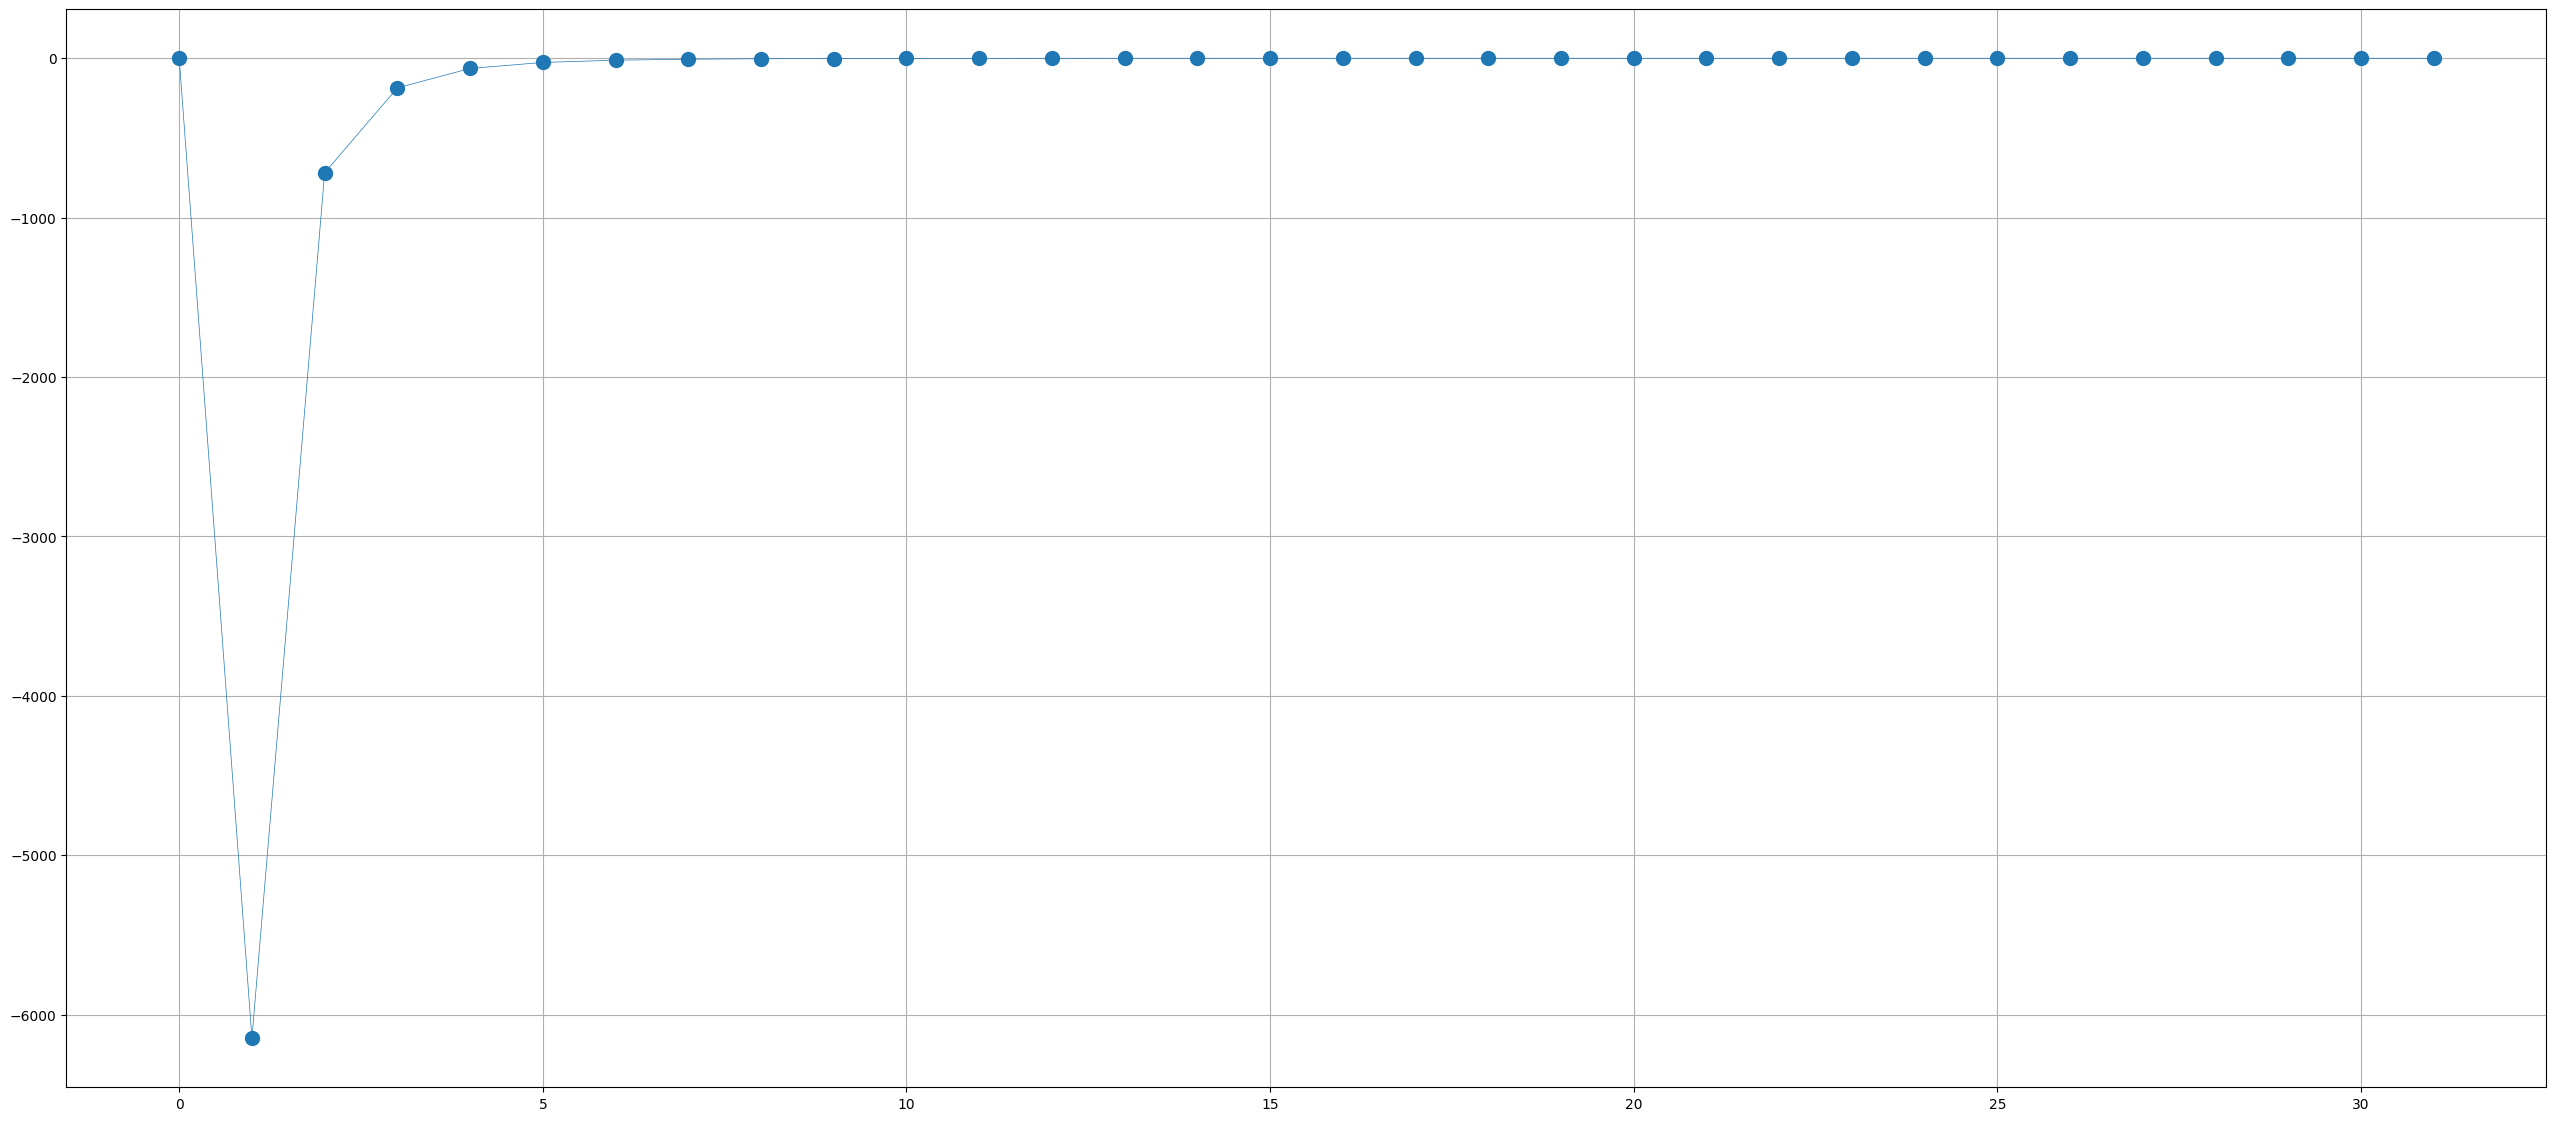

In [23]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax_list.errorbar(times,jack_mean_x[0,:].real,yerr=jack_std_x[0,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
ax_list.grid()
        

plt.savefig('provax.png')

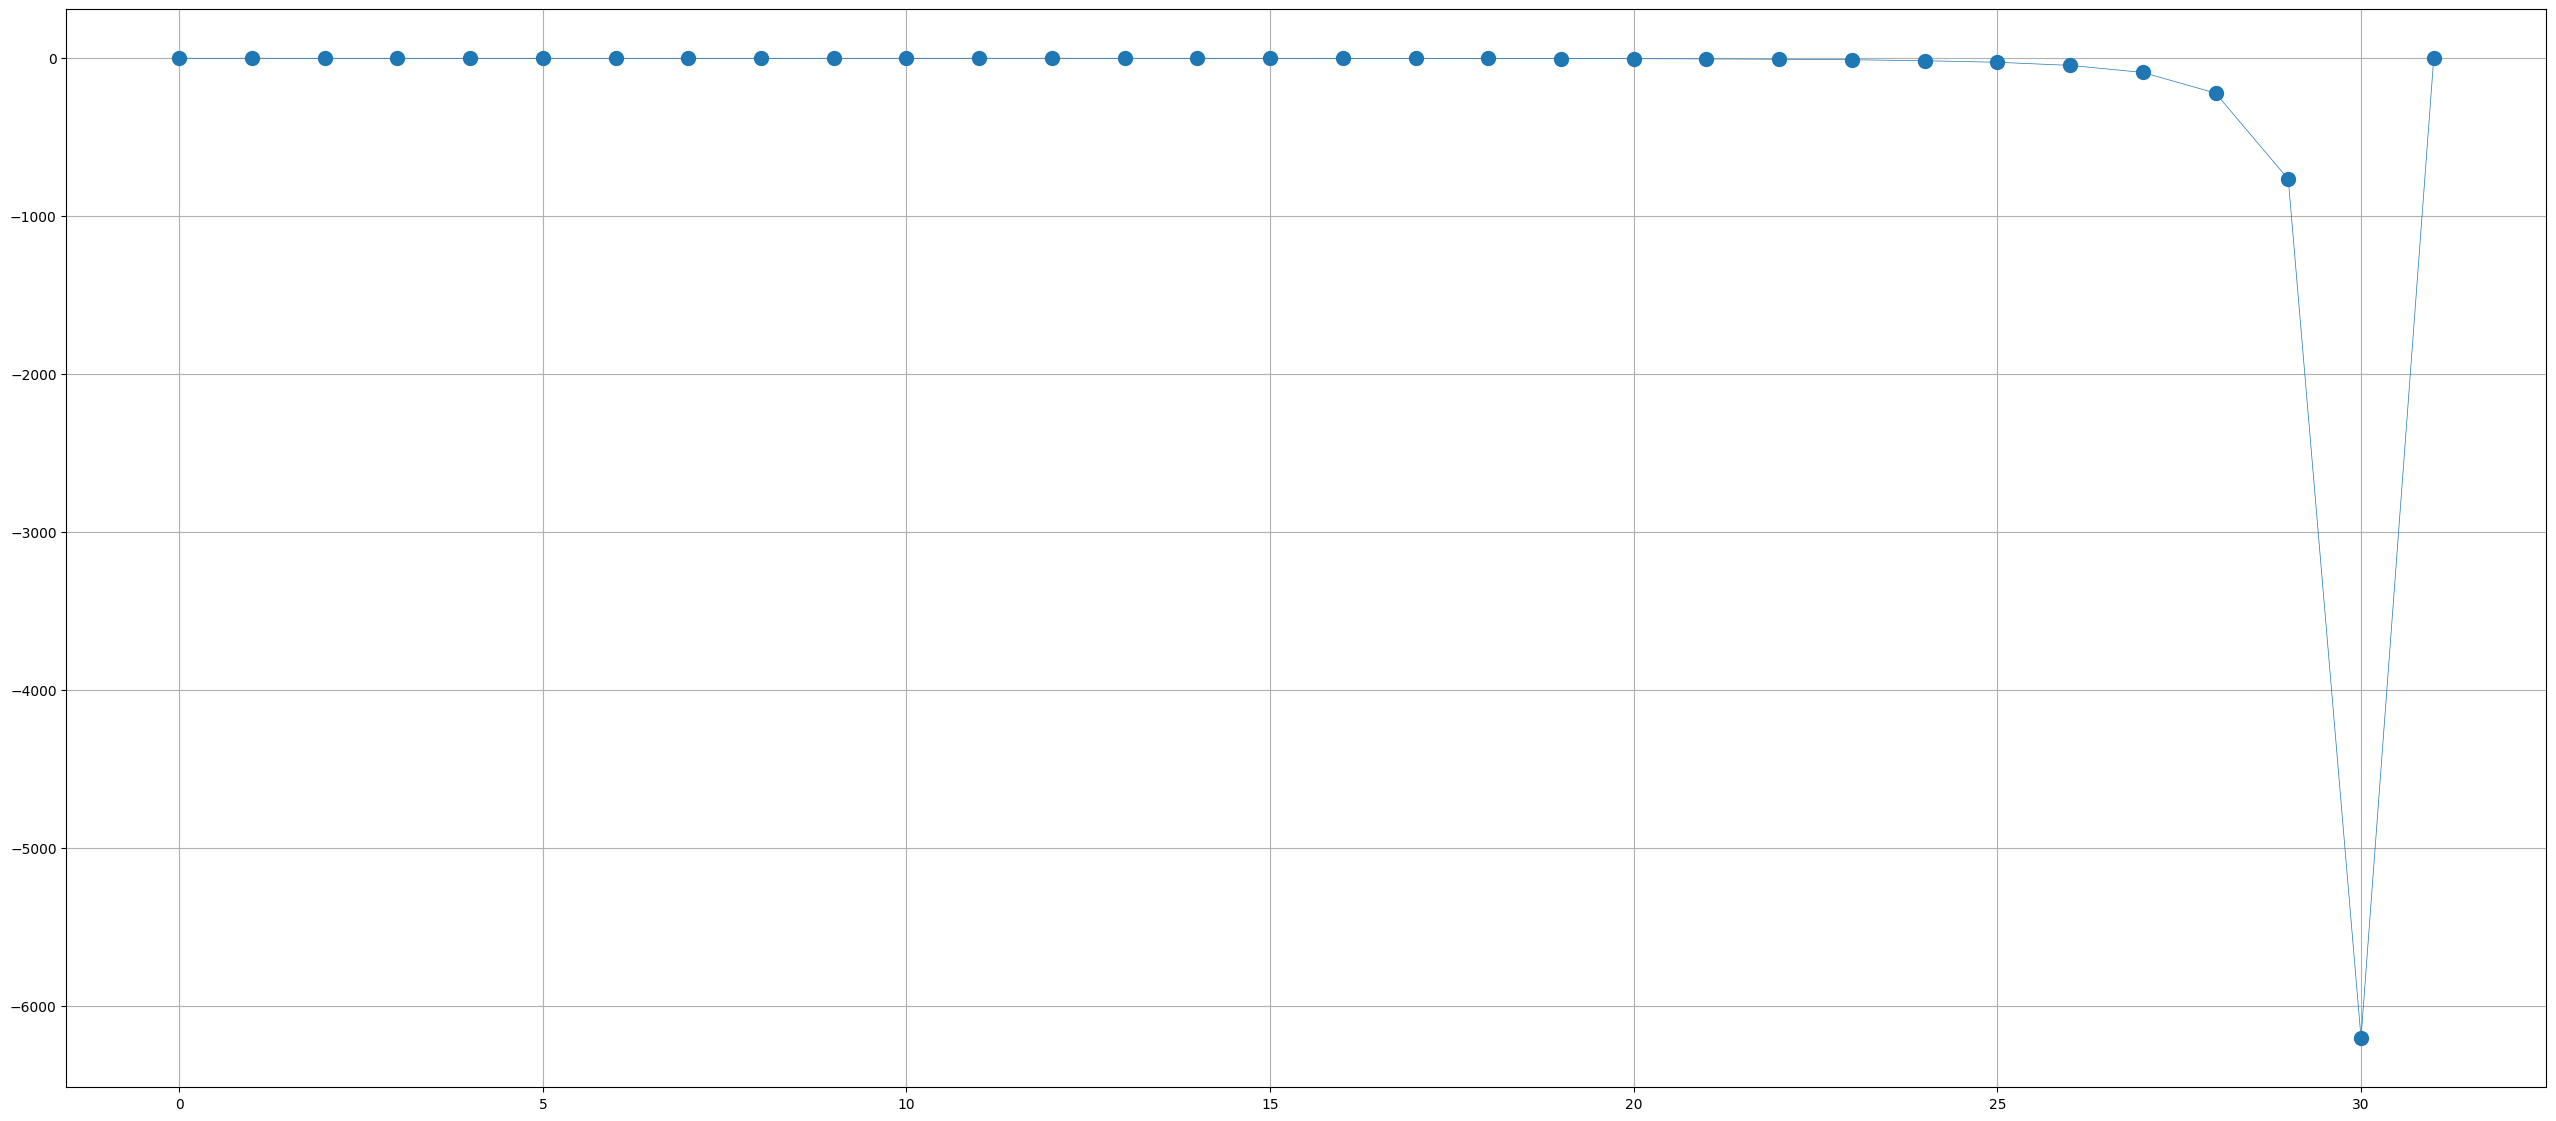

In [24]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

_ = ax_list.errorbar(times,jack_mean_z[0,:].real,yerr=jack_std_z[0,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
ax_list.grid()
        

plt.savefig('provaz.png')

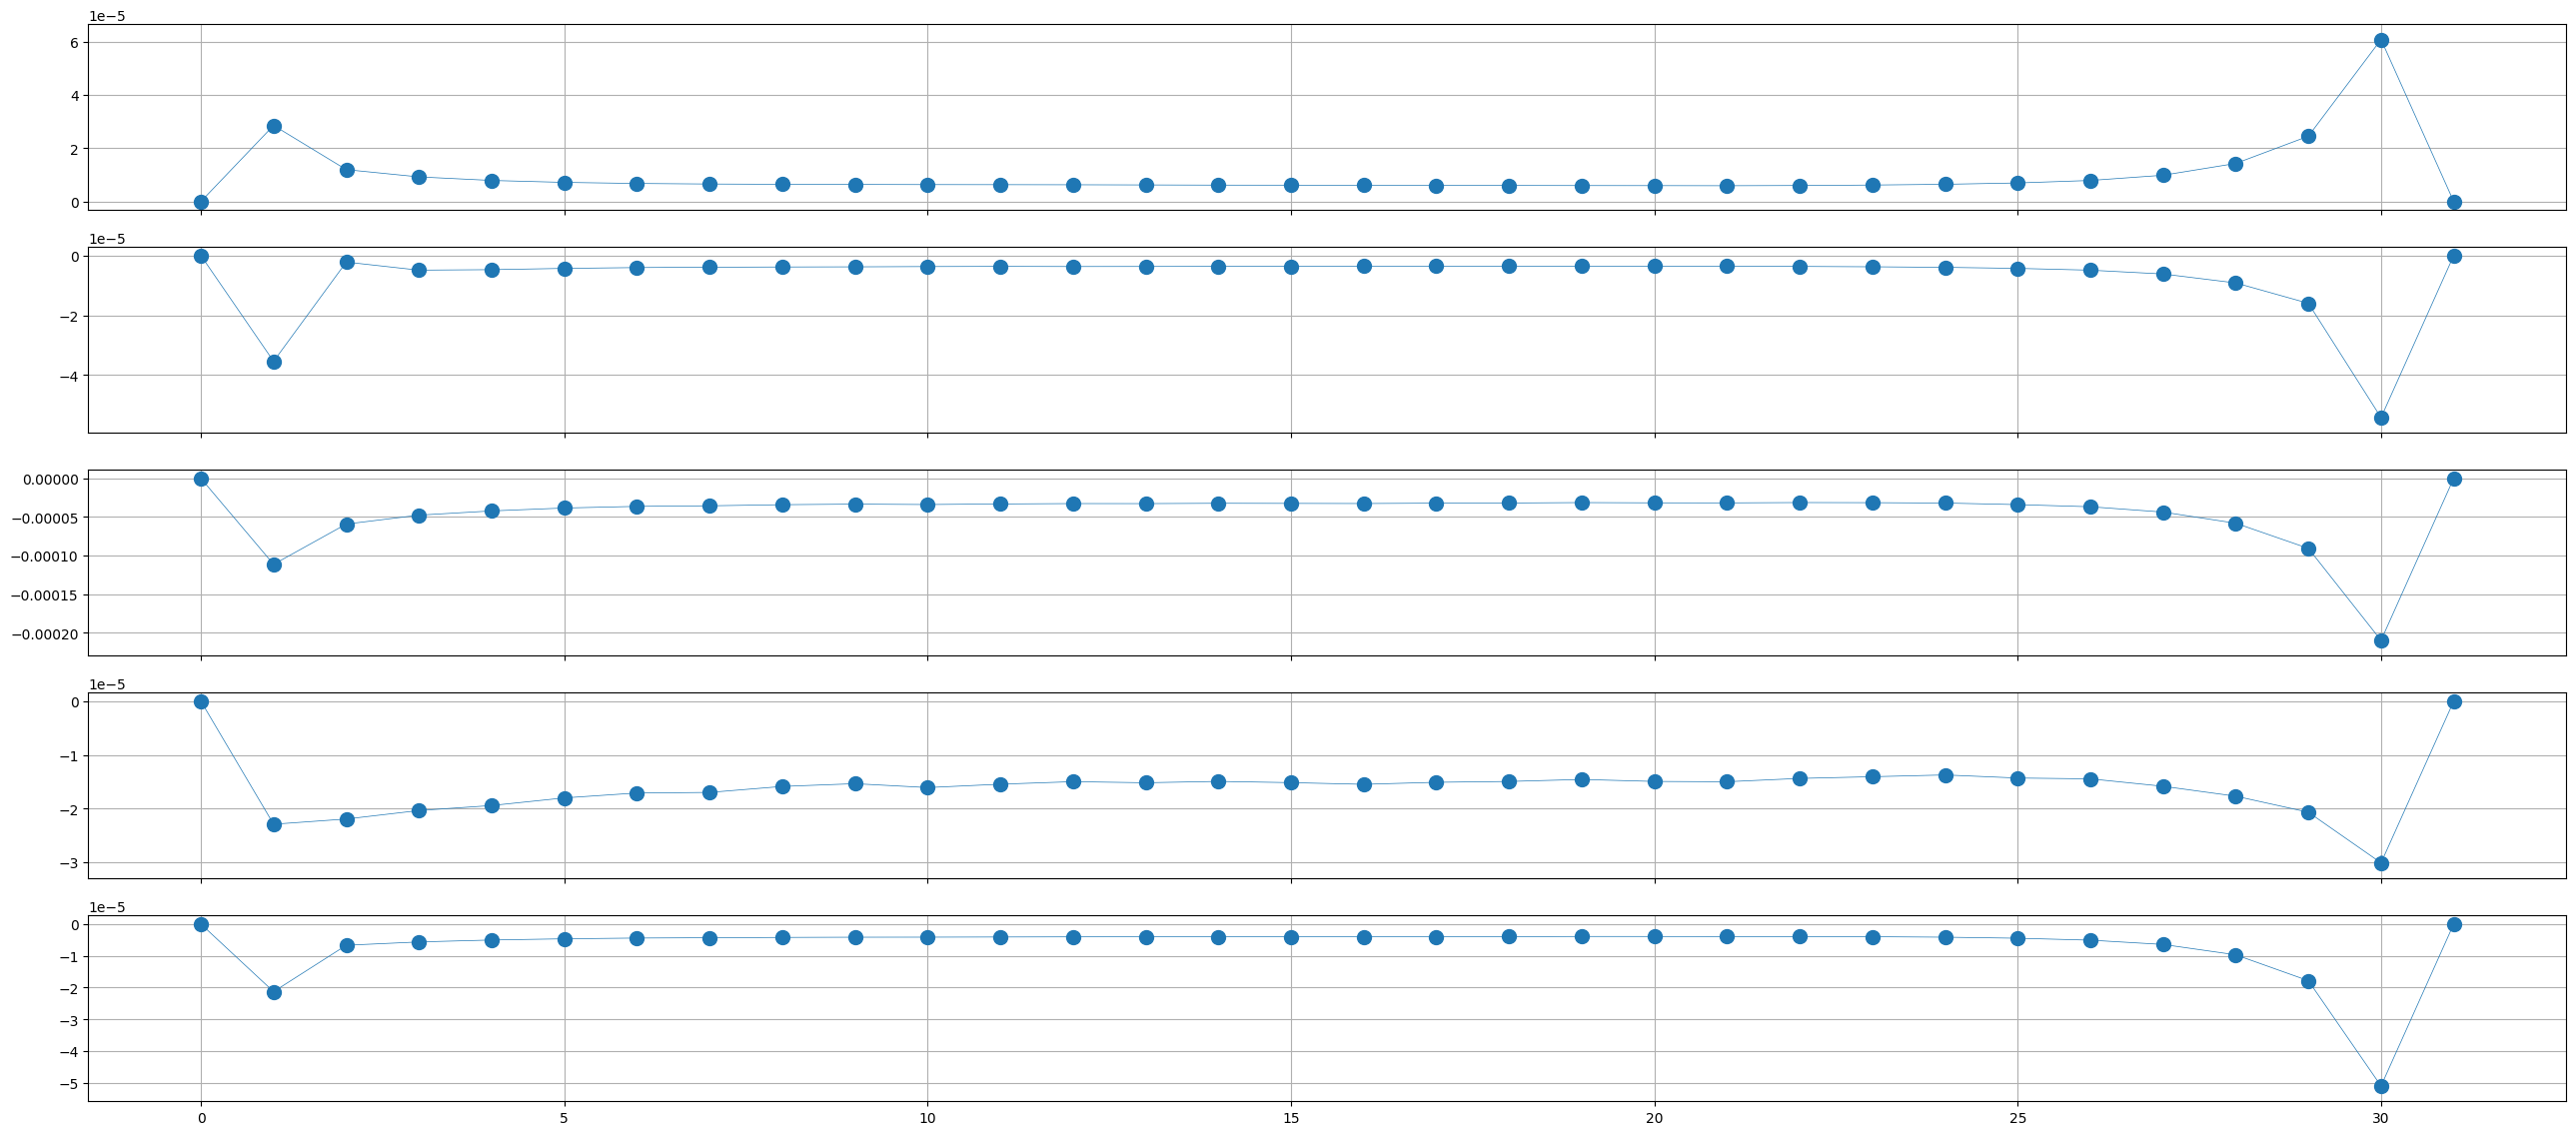

In [25]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,jack_mean_3[0,iop,:].imag,yerr=jack_std_3[0,iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[iop].grid()
        

plt.savefig('prova3.png')

# Binning Study

In [26]:
#list of different binning we can try
divisors(nconf)

[1, 151]

In [27]:
#choice of binning: divisors of number of configurations
deltaList = divisors(nconf)[:-1]

#list to be filled with the mean relative errors
rel_err_x = []
rel_err_z =[]
rel_err_3 =[]
rel_err_norm =[]

#loop over different bin size
for delta in deltaList:


    #creation of list of elements to be deleted
    delete_list = [list(range(iconf,min(iconf+delta,nconf))) for iconf in range(0,nconf,delta)]

    #creation of jackknife replicates (individual for x,z,3)
    jack_replicates_x = np.asarray( [np.delete(all_2point_x_navg, ith_delete ,axis=0).mean(axis=0) for ith_delete in delete_list ] )
    jack_replicates_z = np.asarray( [np.delete(all_2point_z_navg, ith_delete ,axis=0).mean(axis=0) for ith_delete in delete_list ] )
    jack_replicates_3 = np.asarray( [np.delete(all_correlators_navg_tot, ith_delete ,axis=0).mean(axis=0) for ith_delete in delete_list ] )

    #number of replicates
    nreplicates = np.shape(jack_replicates_3)[0] #=nconf/delta

    #creation of jackknife replicates (3 normalized to x*z)
    norm_3point = np.empty(shape=(nreplicates,ncorr,noperators,tvals),dtype=complex)

    for irep in range(nreplicates):
        for icorr in range(ncorr):
            for iop in range(noperators):
                norm_3point[irep,icorr,iop,:] = jack_replicates_3[irep,icorr,iop,:]/(jack_replicates_x[irep,icorr,:]*jack_replicates_z[irep,icorr,:])

    
   
    #computation of mean and std
    jack_mean_x = jack_replicates_x.mean(axis=0)
    jack_std_x = np.sqrt( ((nreplicates-1)/nreplicates) * np.sum( (jack_replicates_x.real-jack_mean_x.real)**2 ,axis=0) )

    jack_mean_z = jack_replicates_z.mean(axis=0)
    jack_std_z = np.sqrt( ((nreplicates-1)/nreplicates) * np.sum( (jack_replicates_z.real-jack_mean_z.real)**2 ,axis=0) )

    jack_mean_3 = jack_replicates_3.mean(axis=0)
    jack_std_3 = np.sqrt( ((nreplicates-1)/nreplicates) * np.sum( (jack_replicates_3.imag-jack_mean_3.imag)**2 ,axis=0) )

    jack_mean_norm = norm_3point.mean(axis=0)
    jack_std_norm = np.sqrt( ((nreplicates-1)/nreplicates) * np.sum( (norm_3point.imag-jack_mean_norm.imag)**2 ,axis=0) )

    #computation of relative error
    errx = np.mean( (jack_std_x/np.abs(jack_mean_x.real))[:,1:-1] )
    errz = np.mean( (jack_std_z/np.abs(jack_mean_z.real))[:,1:-1] )
    err3 = np.mean( (jack_std_3/np.abs(jack_mean_3.imag))[:,:,1:-1] )
    errnorm = np.mean( (jack_std_norm/np.abs(jack_mean_norm.imag))[:,:,1:-1] )

    #store into list
    rel_err_x.append(errx)
    rel_err_z.append(errz)
    rel_err_3.append(err3)
    rel_err_norm.append(errnorm)

    if verbose:
        print(errx)
        print(errz)
        print(err3)
        print(errnorm)
        print("\n")

0.05863402761586915
0.016450313067985032
0.033619084988099
0.06574316721809097




/tmp/ipykernel_17316/928399190.py:31: RuntimeWarning: invalid value encountered in divide
  norm_3point[irep,icorr,iop,:] = jack_replicates_3[irep,icorr,iop,:]/(jack_replicates_x[irep,icorr,:]*jack_replicates_z[irep,icorr,:])
/tmp/ipykernel_17316/928399190.py:49: RuntimeWarning: invalid value encountered in divide
  errx = np.mean( (jack_std_x/np.abs(jack_mean_x.real))[:,1:-1] )
/tmp/ipykernel_17316/928399190.py:50: RuntimeWarning: invalid value encountered in divide
  errz = np.mean( (jack_std_z/np.abs(jack_mean_z.real))[:,1:-1] )
/tmp/ipykernel_17316/928399190.py:51: RuntimeWarning: invalid value encountered in divide
  err3 = np.mean( (jack_std_3/np.abs(jack_mean_3.imag))[:,:,1:-1] )


Text(0.5, 1.0, 'Normalized Standard Deviation as a function of the binsize $\\Delta$ - source in $x_0$')

Text(0.5, 0, '$\\Delta$')

Text(0, 0.5, '$\\sigma$ / $|\\mu|$')

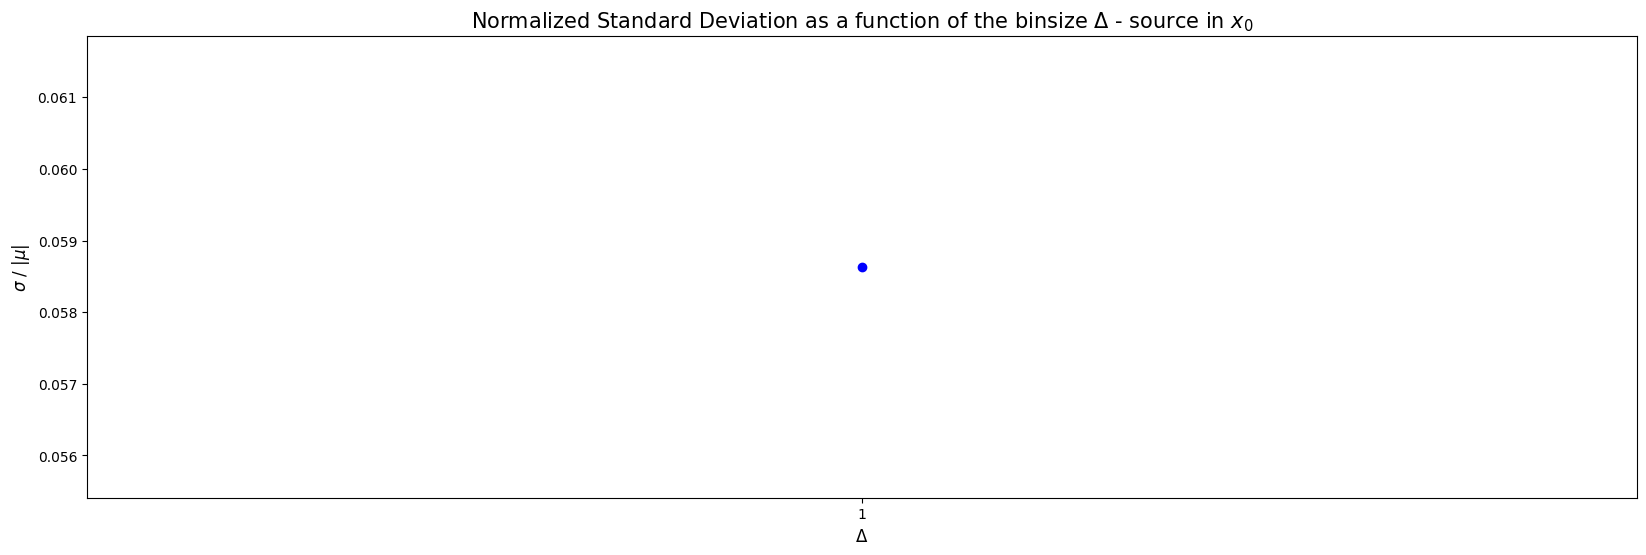

In [28]:
fig = plt.figure(figsize=(20,6))
_=plt.plot(deltaList,rel_err_x,'-o',linewidth=0.1,color='blue',label='errx')
_=plt.xticks(deltaList)
#_=plt.legend()

plt.title(r"Normalized Standard Deviation as a function of the binsize $\Delta$ - source in $x_0$",fontsize=15)
plt.xlabel(r"$\Delta$",fontsize=12)
plt.ylabel(r"$\sigma$ / $|\mu|$",fontsize=12)

plt.savefig("err_vs_bin_x.png")

Text(0.5, 1.0, 'Normalized Standard Deviation as a function of the binsize $\\Delta$ - source in $z_0$')

Text(0.5, 0, '$\\Delta$')

Text(0, 0.5, '$\\sigma$ / $|\\mu|$')

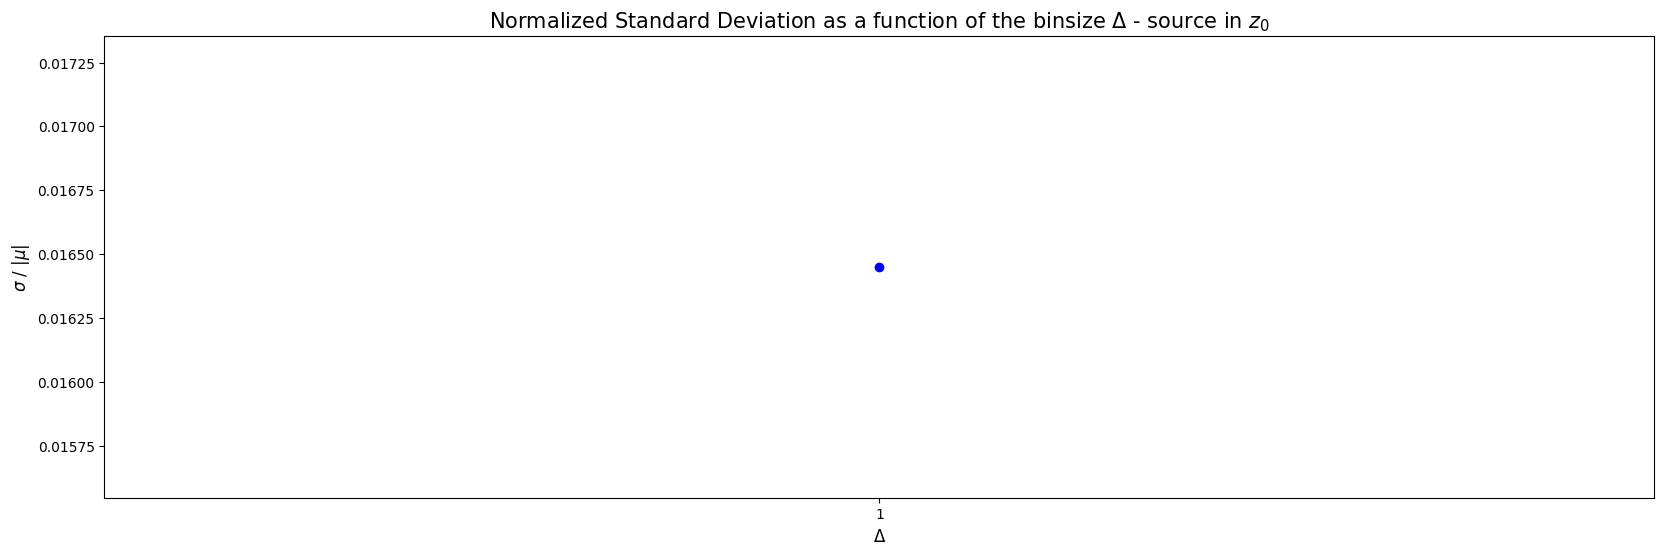

In [29]:
fig = plt.figure(figsize=(20,6))
_=plt.plot(deltaList,rel_err_z,'-o',linewidth=0.1,color='blue',label='errz')
_=plt.xticks(deltaList)
#_=plt.legend()

plt.title(r"Normalized Standard Deviation as a function of the binsize $\Delta$ - source in $z_0$",fontsize=15)
plt.xlabel(r"$\Delta$",fontsize=12)
plt.ylabel(r"$\sigma$ / $|\mu|$",fontsize=12)

plt.savefig("err_vs_bin_z.png")

Text(0.5, 1.0, 'Normalized Standard Deviation as a function of the binsize $\\Delta$ - 3 point correlators')

Text(0.5, 0, '$\\Delta$')

Text(0, 0.5, '$\\sigma$ / $|\\mu|$')

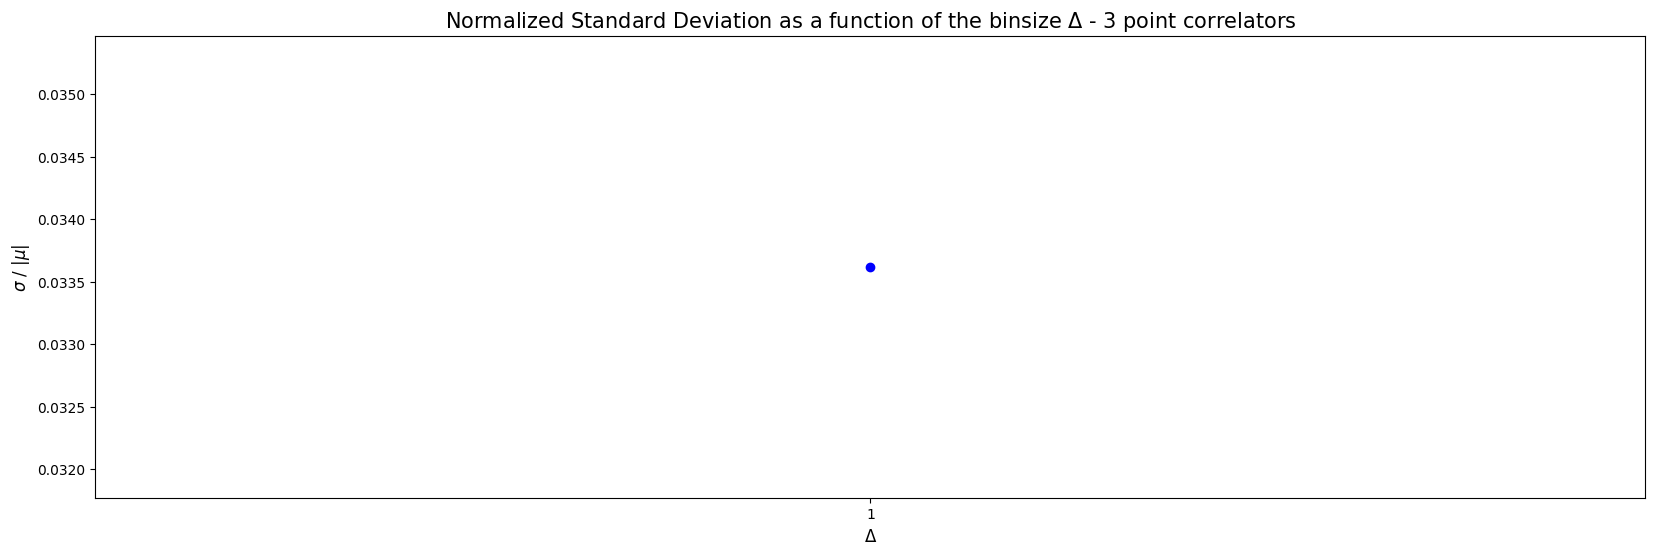

In [30]:
fig = plt.figure(figsize=(20,6))
_=plt.plot(deltaList,rel_err_3,'-o',linewidth=0.1,color='blue',label='err3')
_=plt.xticks(deltaList)
#_=plt.legend()

plt.title(r"Normalized Standard Deviation as a function of the binsize $\Delta$ - 3 point correlators",fontsize=15)
plt.xlabel(r"$\Delta$",fontsize=12)
plt.ylabel(r"$\sigma$ / $|\mu|$",fontsize=12)

plt.savefig("err_vs_bin_3.png")

Text(0.5, 1.0, 'Normalized Standard Deviation as a function of the binsize $\\Delta$ - normalized correlators')

Text(0.5, 0, '$\\Delta$')

Text(0, 0.5, '$\\sigma$ / $|\\mu|$')

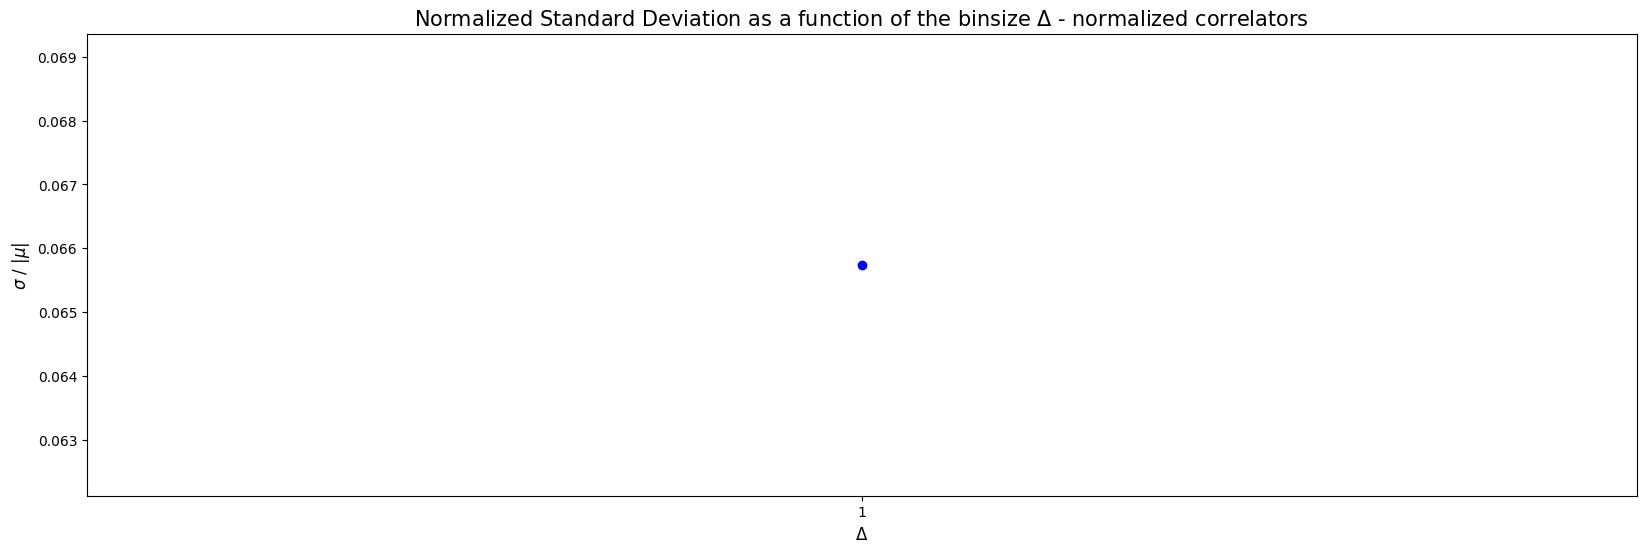

In [31]:
fig = plt.figure(figsize=(20,6))
_=plt.plot(deltaList,rel_err_norm,'-o',linewidth=0.1,color='blue',label='signorm')
_=plt.xticks(deltaList)
#_=plt.legend()

plt.title(r"Normalized Standard Deviation as a function of the binsize $\Delta$ - normalized correlators",fontsize=15)
plt.xlabel(r"$\Delta$",fontsize=12)
plt.ylabel(r"$\sigma$ / $|\mu|$",fontsize=12)

plt.savefig("err_vs_bin_norm.png")

In [32]:
a = np.array([1,2,3])
a**2
(a-1)**2
np.sum((a-1)**2)

array([1, 4, 9])

array([0, 1, 4])

5